Step 1.1: Load Data

In [12]:
from deepdow.benchmarks import OneOverN, Random
from deepdow.callbacks import EarlyStoppingCallback
from deepdow.data import InRAMDataset
from deepdow.data import RigidDataLoader
from deepdow.experiments import Run
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown, CumulativeReturn
from deepdow.nn import BachelierNet
from deepdow.utils import raw_to_Xy
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from pandas_ta import Imports
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import torch
import yfinance as yf

# CREDIT TO DeepDow library
# This project utilizes DeepDow framework which provides and end-to-end Machine Learning based Portfloio Allocation. 
# Our primary focus is on feature engineering and tuning hyperparameters to show improvement of portfolio allocation using ML model.


In [13]:
# DEFINE EXPERIMENT PARAMETER (incl. Hyperparameters) HERE

tickers = ['GOOG','V','JNJ','T','DIS']
start = '2013-01-01'
end = '2023-12-31'

lookback, gap, horizon = 10, 1, 5

In [14]:

original = yf.download(tickers, start=start, end=end)
print('original', original.shape)

[*********************100%%**********************]  5 of 5 completed

original (2768, 30)


Step 1.2: Add Features

In [19]:
features = {
    'RSI': [],
    'MACD_12_26_9': [],
    'MACDh_12_26_9': [],
    'MACDs_12_26_9': [],
    'BBL_5_2.0': [],
    'BBM_5_2.0': [],
    'BBU_5_2.0': [],
    'BBB_5_2.0': [],
    'BBP_5_2.0': [],
    'STOCHk_14_3_3': [],
    'STOCHd_14_3_3': [],
}
closes = original['Adj Close']
volumes = original['Volume']

print('closes', closes.shape)
print('volumes', volumes.shape)

scale_min = 0.01
scale_max = 1.00

for ticker in closes.columns:
    close = pd.DataFrame(closes[ticker])
    close.columns = ['close']

    volume = pd.DataFrame(volumes[ticker])
    volume.columns = ['volume']

    rsi = close.ta.rsi()
    rsi = pd.DataFrame(close.ta.rsi().values, index=rsi.index, columns=['RSI'])
    rsi = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(rsi), index=rsi.index, columns=rsi.columns)
    features['RSI'].append(rsi['RSI'])
    
    macd = close.ta.macd()
    macd = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(macd), index=macd.index, columns=macd.columns)
    for c in macd.columns:
        features[c].append(macd[c])
    
    bbands = close.ta.bbands()
    bbands = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(bbands), index=bbands.index, columns=bbands.columns)
    for c in bbands.columns:
        features[c].append(bbands[c])
    
    stoch = close.copy()
    stoch['high'] = stoch['close'].rolling(lookback).max()
    stoch['low'] = stoch['close'].rolling(lookback).min()
    stoch.ta.stoch(append=True)
    stoch = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(stoch), index=stoch.index, columns=stoch.columns)
    for c in ['STOCHk_14_3_3', 'STOCHd_14_3_3']:
        features[c].append(stoch[c])

raw_df = original.copy()

for k, v in features.items():
    features[k] = pd.concat(v, axis=1)
    features[k].columns = closes.columns
    for col in closes.columns:
        raw_df[(k, col)] = features[k][col]
raw_df

closes (2768, 5)
volumes (2768, 5)


Price       Adj Close                                                 \
Ticker            DIS        GOOG         JNJ          T           V   
Date                                                                   
2013-01-02  46.303730   18.013729   51.974964  11.472698   35.874546   
2013-01-03  46.403419   18.024191   51.901592  11.479258   35.902256   
2013-01-04  47.291424   18.380356   52.495895  11.548091   36.195477   
2013-01-07  46.185940   18.300158   52.385838  11.600538   36.454067   
2013-01-08  45.995651   18.264042   52.393173  11.452443   36.793468   
...               ...         ...         ...        ...         ...   
2023-12-22  91.019997  142.720001  154.288544  16.284359  257.949005   
2023-12-26  90.949997  142.820007  154.963409  16.304037  258.677643   
2023-12-27  90.379997  141.440002  155.171844  16.313877  258.448059   
2023-12-28  90.400002  141.279999  155.400101  16.471310  259.915344   
2023-12-29  90.290001  140.929993  155.558899  16.510668  259.865448   

Price           Close                                                 ...  \
Ticker            DIS        GOOG         JNJ          T           V  ...   
Date                                                                  ...   
2013-01-02  51.099998   18.013729   70.839996  26.435045   38.845001  ...   
2013-01-03  51.209999   18.024191   70.739998  26.450151   38.875000  ...   
2013-01-04  52.189999   18.380356   71.550003  26.608761   39.192501  ...   
2013-01-07  50.970001   18.300158   71.400002  26.729607   39.472500  ...   
2013-01-08  50.759998   18.264042   71.410004  25.944109   39.840000  ...   
...               ...         ...         ...        ...         ...  ...   
2023-12-22  91.019997  142.720001  155.460007  16.549999  258.429993  ...   
2023-12-26  90.949997  142.820007  156.139999  16.570000  259.160004  ...   
2023-12-27  90.379997  141.440002  156.350006  16.580000  258.929993  ...   
2023-12-28  90.400002  141.279999  156.580002  16.740000  260.399994  ...   
2023-12-29  90.290001  140.929993  156.740005  16.780001  260.350006  ...   

Price      STOCHk_14_3_3                                          \
Ticker               DIS      GOOG       JNJ         T         V   
Date                                                               
2013-01-02           NaN       NaN       NaN       NaN       NaN   
2013-01-03           NaN       NaN       NaN       NaN       NaN   
2013-01-04           NaN       NaN       NaN       NaN       NaN   
2013-01-07           NaN       NaN       NaN       NaN       NaN   
2013-01-08           NaN       NaN       NaN       NaN       NaN   
...                  ...       ...       ...       ...       ...   
2023-12-22      0.187460  0.987348  0.531259  0.369340  0.660400   
2023-12-26      0.167357  1.000000  0.599162  0.370054  0.683492   
2023-12-27      0.071557  0.962641  0.637937  0.382066  0.638408   
2023-12-28      0.040053  0.920951  0.678093  0.440330  0.697615   
2023-12-29      0.011473  0.869786  0.692870  0.505000  0.739216   

Price      STOCHd_14_3_3                                          
Ticker               DIS      GOOG       JNJ         T         V  
Date                                                              
2013-01-02           NaN       NaN       NaN       NaN       NaN  
2013-01-03           NaN       NaN       NaN       NaN       NaN  
2013-01-04           NaN       NaN       NaN       NaN       NaN  
2013-01-07           NaN       NaN       NaN       NaN       NaN  
2013-01-08           NaN       NaN       NaN       NaN       NaN  
...                  ...       ...       ...       ...       ...  
2023-12-22      0.326927  0.909212  0.588763  0.424008  0.702204  
2023-12-26      0.241697  0.969073  0.574673  0.389694  0.691869  
2023-12-27      0.142125  0.983330  0.589453  0.373820  0.660767  
2023-12-28      0.092989  0.961198  0.638397  0.397483  0.673172  
2023-12-29      0.041028  0.917793  0.669633  0.442465  0.691746  

[2768 rows x 85 colu

In [21]:

df = raw_df.swaplevel(0, 1, 1)
df = df.dropna(axis=0)

assert isinstance(df, pd.DataFrame)
assert isinstance(df.index, pd.DatetimeIndex)
assert isinstance(df.columns, pd.MultiIndex)

n_timesteps = len(df)
n_channels = len(df.columns.levels[1])
n_assets = len(df.columns.levels[0])

print('n_timesteps\t', n_timesteps)
print('n_assets\t', n_assets)
print('n_channels (features)\t', n_channels)
print('features', df.columns.levels[1])

df.head()

n_timesteps	 2735
n_assets	 5
n_channels (features)	 17
features Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_5_2.0',
       'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'STOCHk_14_3_3',
       'STOCHd_14_3_3'],
      dtype='object', name='Price')


Ticker,DIS,GOOG,JNJ,T,V,DIS,GOOG,JNJ,T,V,...,DIS,GOOG,JNJ,T,V,DIS,GOOG,JNJ,T,V
Price,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Close,Close,Close,Close,Close,...,STOCHk_14_3_3,STOCHk_14_3_3,STOCHk_14_3_3,STOCHk_14_3_3,STOCHk_14_3_3,STOCHd_14_3_3,STOCHd_14_3_3,STOCHd_14_3_3,STOCHd_14_3_3,STOCHd_14_3_3
Date,,,,,,,,,,,,,,,,,,,,,
2013-02-20,49.475224,19.737518,56.237740,11.825852,35.959469,54.599998,19.737518,76.650002,26.790030,38.855000,...,0.890000,0.954330,0.976043,0.940280,0.406650,0.959306,0.981430,0.987551,0.921426,0.373928
2013-02-21,49.085587,19.813982,56.399143,11.812516,36.426830,54.169998,19.813982,76.870003,26.759819,39.360001,...,0.738141,0.918404,0.969088,0.937762,0.375343,0.874033,0.957578,0.981710,0.934139,0.406839
2013-02-22,49.158081,19.918093,56.391766,11.895868,36.887245,54.250000,19.918093,76.250000,26.948641,39.857498,...,0.575342,0.895744,0.961355,0.937762,0.478932,0.734494,0.922826,0.968829,0.938601,0.420308
2013-02-25,48.560028,19.695427,55.888870,11.732504,36.068218,53.590000,19.695427,75.570000,26.578550,38.972500,...,0.355342,0.860214,0.922244,0.880703,0.505685,0.556275,0.891454,0.950896,0.918742,0.453320
2013-02-26,48.840931,19.679485,56.021965,11.832517,36.517059,53.900002,19.679485,75.750000,26.805136,39.457500,...,0.225005,0.797822,0.877555,0.883730,0.527881,0.385230,0.851260,0.920385,0.900732,0.504166


Step 2: Reformat Data

Step 3: Prepare X, y

In [22]:
print('- lookback \t', lookback)
print('- gap\t\t', gap)
print('- horizon \t', horizon)
X, timestamps, y, asset_names, indicators = raw_to_Xy(df, lookback=lookback,
                                                      gap=gap, freq="B", horizon=horizon)

print('X', X.shape)
print('y', y.shape)
print('asset_names', asset_names)
print('indicators', indicators)

dataset = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names)

- lookback 	 10
- gap		 1
- horizon 	 5
X (2817, 17, 10, 5)
y (2817, 17, 5, 5)
asset_names ['DIS', 'GOOG', 'JNJ', 'T', 'V']
indicators ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'STOCHk_14_3_3', 'STOCHd_14_3_3']


Step 4: Train Model

In [23]:
train_test_ratio = 0.8
n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
train_ix = list(range(split_ix))
test_ix = list(range(split_ix + lookback + horizon, n_samples))

train_dataloader = RigidDataLoader(dataset, indices=train_ix, batch_size=32)
test_dataloader = RigidDataLoader(dataset, indices=test_ix, batch_size=32)

In [24]:
max_weight = 0.5
hidden_size = 32
network = BachelierNet(n_channels, n_assets, hidden_size=hidden_size, max_weight=max_weight)
loss = SharpeRatio(returns_channel=0)
benchmarks = {'1overN': OneOverN()}
metrics = {'drawdown': MaximumDrawdown(),
           'cumreturn': CumulativeReturn()
           }


run = Run(network,
          loss,
          train_dataloader,
          val_dataloaders={'test': test_dataloader},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15)])

history = run.launch(n_epochs=20)

Epoch 19: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s, loss=-0.17557, test_loss=0.01168]


Reference: The evaluation and visualization code was from DeepDow example.

In [25]:
per_epoch_results = history.metrics.groupby(
    ['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model    epoch
test        loss    network  0        529
                             1        529
                             2        529
                             3        529
                             4        529
                             5        529
                             6        529
                             7        529
                             8        529
                             9        529
                             10       529
                             11       529
                             12       529
                             13       529
                             14       529
                             15       529
                             16       529
                             17       529
                             18       529
                             19       529
Name: value, dtype: int64
dataloader  metric  model    epoch
test        loss    network  0        0.015288
                 

<Axes: xlabel='epoch'>

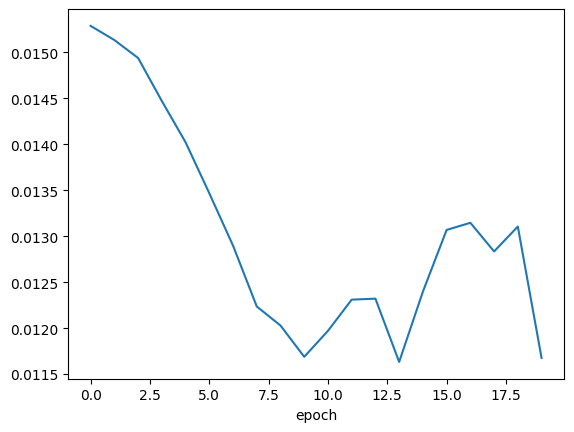

In [26]:
per_epoch_results.mean()['test']['loss']['network'].plot()

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>],
      dtype=object)

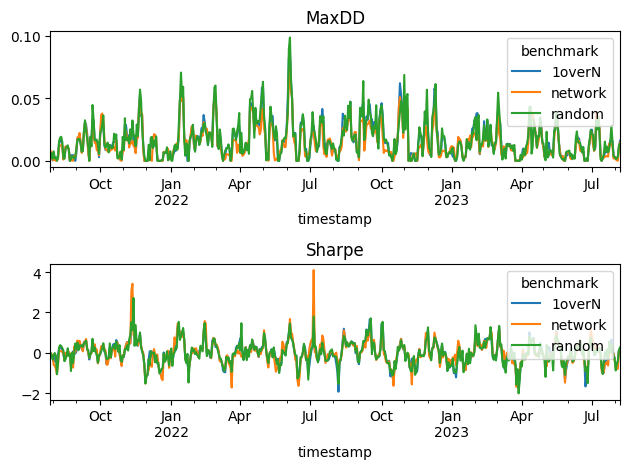

In [27]:

benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'random': Random(),  # random allocation that is however close 1OverN
    'network': network
}
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
}

metrics_table = generate_metrics_table(benchmarks,
                                       test_dataloader,
                                       metrics)
plot_metrics(metrics_table)

array([<Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>,
       <Axes: title={'center': 'CumReturn'}, xlabel='timestamp'>],
      dtype=object)

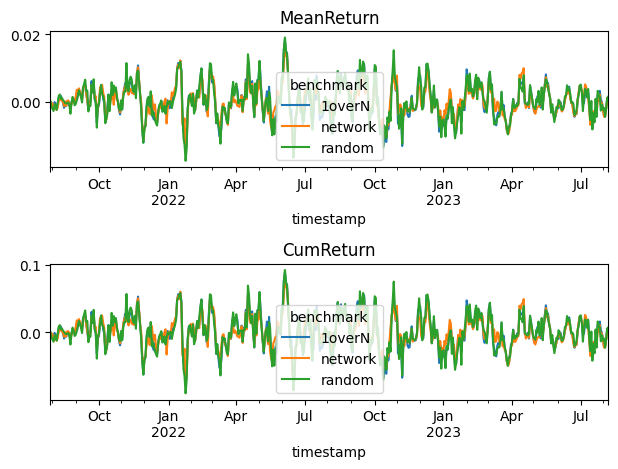

In [28]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'random': Random(),  # random allocation that is however close 1OverN
    'network': network
}
metrics = {
    'MeanReturn': MeanReturns(),
    'CumReturn': CumulativeReturn()
}

metrics_table = generate_metrics_table(benchmarks,
                                       test_dataloader,
                                       metrics)
plot_metrics(metrics_table)

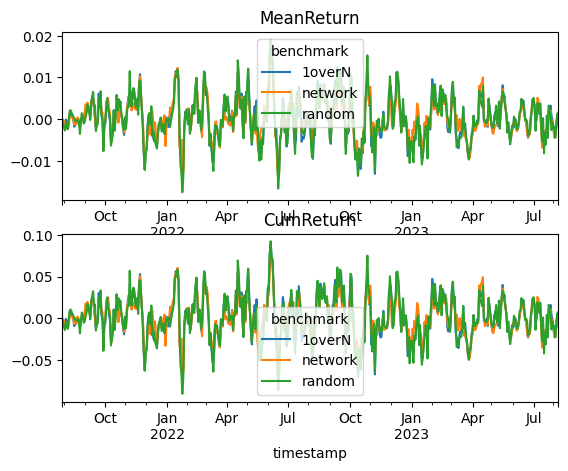

In [29]:
import matplotlib.pyplot as plt

all_metrics = metrics_table["metric"].unique()
n_metrics = len(all_metrics)

_, axs = plt.subplots(n_metrics)

for i, metric_name in enumerate(all_metrics):
    df = pd.pivot_table(
        metrics_table[metrics_table["metric"] == metric_name],
        values="value",
        columns="benchmark",
        index="timestamp",
    ).sort_index()
    df.plot(ax=axs[i])
    axs[i].set_title(metric_name)

plt.show()

<Axes: >

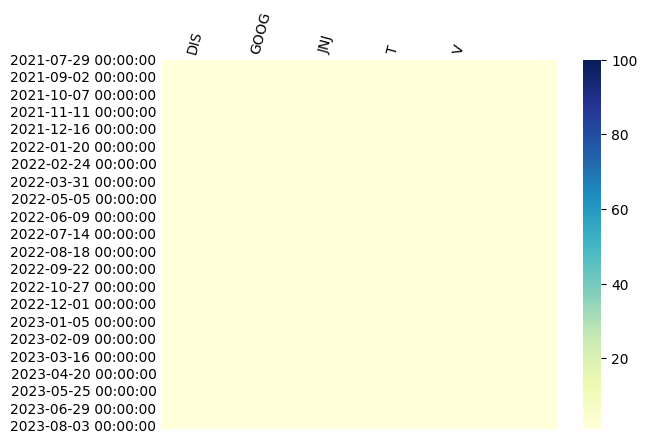

In [30]:

weight_table = generate_weights_table(network, test_dataloader)

plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25,
                    vmin=100)